# Letal COVID-19 snRNA Analysis
# Section 2: Normalization
Author: MikiasHWT  
Start: December 9, 2024  

In [59]:
from datetime import datetime
current_date = datetime.now().strftime("%B %d, %Y")
print(f"Updated: {current_date}")

Updated: December 19, 2024


# Prologue 

Consider the human mind's limitations with the following thoughts: 
- Given a graduated cylinder with a certain amount of liquid, we can quite easily estimate the level we would reach if we doubled the liquid. Yet if we are asked to do the same with an Erlynmyer flask, we will generally be incorrect in our guess. 
- Estimate the number of times any given size or thickness of paper can be folded. Now try it out. It often takes us by suprise that we can only fold a paper (regardless of its size or its thickness) 7 or 8 times. 
- Lastly, note that 1 Million seconds is about 11 days but 1 Billion seconds is about 32 years. Setting aside thoughts of soon-to-be Trillionairs, this factoid often takes people by surpise. 

These examples illustrate how our minds struggle with nonlinear relationships and vast magnitudes, much like how raw data can be difficult to interpret without normalization and transformation. By adjusting values to defined ranges and scales, we simplify the interpretation process for both humans and algorithms.

# Background

The process of RNA sequencing involves many steps that introduce bias into our counts data. 

- Technican variability: Two identical cells can have highly different counts for any given gene due to differences in processing, reverse transcription, amplificiation and sequencing steps. This results in two cells that for all intents and purposes are identical, appearing to have biologically relevant differences in gene signatures. The use of Unique Molecular Identifiers help reduce the technical noise produced during PCR, but cannot account for other steps of variability production.  

- Gene size variability: Larger genes will have more sequencing targets than smaller genes and may appear to have higher expression because of that fact. 

- Mean-Variance: The ground truth of RNA amplification has long been considered to fall along a logrithmic distribution, specifically a log 2 transformation. The reality is in fact convoluded by various factors such as feedback loops, signaling pathways, environmental factors, selective inhibition, and transcriptional bursts. As such, log based normalization methods cannot perfectly account for over dispersian of RNA expression. A Poisson based model with a Gamma scaling facor has been discovered to better fit RNA expression varibility.

- Downstream Statistics: Lastly, many downstream analysis methodologies require normalized data in order to apply statistical methods. These include but are not limited to Clustering and dimensionality reduction, differential gene expression and pathway analyses. (Some pipelines may require raw data in order to apply their own normalization methods)

Various normalization methods can be applied to data and much like the quality control portion of our workflow, data normalization requires careful consideration of the question at hand as well as an idea of what downstream analyses will be used. 

For our case we will apply an analytic approximation of Pearson residuals. [Normalization and variance stabilization of single-cell RNA-seq data using regularized negative binomial regression](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1)

## Objective

- Explore Data Distributions
- Compare Normalization Methods
- Apply Optimal Normalization 

# Prep Workspace

## Import Libraries

In [60]:
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns  # Statistical data visualization
import scanpy as sc  # Single-cell data analysis
import os  # Operating system interface

In [61]:
import warnings  
import anndata2ri  # For AnnData & Single Cell Experiment Compatibility
import logging  
from scipy.sparse import issparse, csr_matrix  # For sparse matrix handling
import scanpy as sc 
import rpy2.rinterface_lib.callbacks as rcb  # For managing R callback messages
import rpy2.robjects as ro  # Core rpy2 object for interacting with R

# Activate pandas2ri and anndata2ri converters
from rpy2.robjects import pandas2ri
pandas2ri.activate()  # Converting pandas df's between Python and R
anndata2ri.activate()  # Converting AnnData objects between Python and R

# Scanpy settings
sc.settings.verbosity = 0  # Suppress verbose messages
sc.settings.set_figure_params(
    dpi=80,  
    facecolor="white", 
    frameon=False, 
)

ro.r('options(device="windows")')  # Ensures compatibility for plotting on Windows

rcb.logger.setLevel(logging.ERROR)  # Suppres rpy2 logging messages

warnings.filterwarnings("ignore", category=DeprecationWarning) # Suppress DeprecationWarnings

# Load the rpy2 IPython magic
%load_ext rpy2.ipython 

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [62]:
%%R
# Load R packages & Mute output
suppressMessages({
    library(scran)
    library(BiocParallel)
})

## Define Functions

In [63]:
# Define function to plot transformation histograms
def plot_layer_histograms(adata, transform_tuple, nrows=1, ncols=5, figsize=(24, 6)):
    """
    Plots histograms of data transformations stored in the layers of an AnnData object.

    Parameters:
    - adata: AnnData
        The AnnData object containing data layers to be plotted.
    - transform_tuple: List[Tuple[str, str]]
        A list of tuples where:
            - The first element (str) is the name of a layer in adata.layers.
            - The second element (str) is the title for the corresponding subplot.
    - nrows: int, optional (default=1)
        Number of rows in the subplot grid.
    - ncols: int, optional (default=4)
        Number of columns in the subplot grid.
    - figsize: Tuple[int, int], optional (default=(24, 6))
        The overall figure size (width, height).

    Returns:
    - None
        Displays the histograms for the specified layers.
    """
    # Set up subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten axes for easy iteration
    
    for i, (layer, title) in enumerate(transform_tuple):
        if layer in adata.layers:
            data = adata.layers[layer].sum(1) # Sum across cells for the given layer
            sns.histplot(data, bins=100, kde=False, ax=axes[i])
            axes[i].set_title(title)
        else:
            axes[i].set_visible(False) # Error handling
        
    plt.tight_layout()
    plt.show()

## Directories

In [64]:
# Define directories 
datDir = os.path.abspath("data")
outDir = os.path.abspath("output")

# List their contents. 
for path in [datDir, outDir]:
    # os.makedirs(path, exist_ok=True)   # Optional: Create directories if they dont exist
    print(f"Contents of {path}:")
    print("\n".join(os.listdir(path)) or "Directory is empty", "\n")

Contents of c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\data:
adata_C51ctr.h5ad
C51ctr_QC.h5ad
COVID19_QCd_Pooled_Samples.h5ad
GSE171524_RAW
GSE171524_RAW.tar
ref
Supplementary_Table1_Clinical_Information.xlsx
Uncompressed_adata_C51ctr.h5ad 

Contents of c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\output:
Directory is empty 



## Import Data

In [65]:
data_files = os.listdir(datDir)
data_files

['adata_C51ctr.h5ad',
 'C51ctr_QC.h5ad',
 'COVID19_QCd_Pooled_Samples.h5ad',
 'GSE171524_RAW',
 'GSE171524_RAW.tar',
 'ref',
 'Supplementary_Table1_Clinical_Information.xlsx',
 'Uncompressed_adata_C51ctr.h5ad']

In [66]:
# Read single sample we QC'd in the earlier section
adata = sc.read_h5ad("data/C51ctr_QC.h5ad")
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'outlier_temp_colors'

In [67]:
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'outlier_temp_colors'

In [68]:
# Save raw counts as a layer
adata.layers["counts"] = csr_matrix(adata.X.copy())

# Norm & Transform

The process of converting our data into usable ranges for downstream analysis typically begins with normalizing the values. **Normalization adjusts the data to a specific range or scale, ensuring that features contribute equally to the analysis and are not dominated by differences in magnitude or sequencing depth between cells/genes.** Common methods for normalization include min-max scaling, which scales values to a defined range (e.g., [0, 1]), and z-score scaling, which standardizes data based on the mean and standard deviation. This step results in a well-defined range of expression values, making patterns in the data more interpretable and easier for the human mind to grasp.

After normalization, we often apply a transformation to further refine the data. **Transformations are used to adjust the distribution of values, mitigate skewness, or highlight meaningful patterns.** For example, logarithmic transformations compress large values and emphasize smaller ones, making relationships between variables clearer. Similarly, square root or power transformations can help stabilize variance across the dataset, ensuring that downstream analyses, such as clustering or dimensionality reduction, are not biased by extreme values.

Normalization and transformation together are critical steps for ensuring that our data is consistent, interpretable, and ready for robust analysis. These steps help reduce noise, improve comparability across samples, and reveal meaningful biological or statistical insights


## PseudoLog Median

Log transformation is commonly used to handle data that spans several orders of magnitude, such as gene expression levels or cell counts. It compresses large values while maintaining smaller ones, making patterns easier to interpret and reducing the influence of outliers. 

For example, in processes like cell division or gene expression, where values often follow exponential growth, log transformation translates multiplicative changes (doubling) into additive ones, simplifying analysis and visualization for downstream tasks. However, since the logarithm of 0 is undefined, we must add a small value (ie: 1) to all our data, hense the name PseudoLog. 

In Scanpy's default workflow, we normalize each cell’s total counts to the median total count across all cells, adjusting for differences in sequencing depth between cells. Then we apply log1p transformation, to stabilizes variance, compresses large values, and highlights meaningful patterns in the data.


In [69]:
# Scale counts
scaled_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)

# log1p transform add as anndata layer
adata.layers["log1p-median"] = csr_matrix(sc.pp.log1p(scaled_counts["X"], copy=True))
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'outlier_temp_colors'
    layers: 'counts', 'log1p-median'

## PseudoLog CP10K

We can also choose to scale our UMI counts to specific values. A common target is 10,000 counts. We name this `PseudoLog Counts Per 10,000`. 

In [70]:
# Scale 
scales_counts_10K = sc.pp.normalize_total(adata, target_sum=1e4, inplace=False)

# log1p transform with 10K UMI Scaling
adata.layers["log1p-CP10K"] = csr_matrix(sc.pp.log1p(scales_counts_10K["X"], copy=True))
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'outlier_temp_colors'
    layers: 'counts', 'log1p-median', 'log1p-CP10K'

## PseudoLog CPM

Counts per Million

In [71]:
# Scale
scales_counts_1M = sc.pp.normalize_total(adata, target_sum=1e6, inplace=False)

# log1p transform with 1 Million UMI Scaling
adata.layers["log1p-CPM"] = csr_matrix(sc.pp.log1p(scales_counts_1M["X"], copy=True))
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'outlier_temp_colors'
    layers: 'counts', 'log1p-median', 'log1p-CP10K', 'log1p-CPM'

## Scran Transformation

Using R's `scran` package we can apply yet another transformatin. This method involves normalizing count data using a deconvolution method to compute size factors for each cell, followed by a pseudolog transformation. The deconvolution method requires us to cluster our cells using unrefined parameters in order to determine size factors. 

Having loaded required R & Python packages in our libraries section, we move between Python and R code to perform this transformation. 

In [72]:
# Preliminary clustering for differentiated normalization
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=12)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

In [73]:
# Prepares count matrix and passes it to R environment
data_mat = adata_pp.X.T
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

# Delete object once passed to R
del adata_pp

In [74]:
%%R -o size_factors
# Compute size factors
size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = SnowParam()
    )
)

In [75]:
# Assign size factors, normalize and log transform
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'outlier_temp_colors'
    layers: 'counts', 'log1p-median', 'log1p-CP10K', 'log1p-CPM', 'scran_normalization'

## Pearson Residuals Transformation

Finally, we can explore the Pearson residuals transformation method, which normalizes count data by addressing the mean-variance relationship. Poisson-distributed data assumes the mean equals the variance, which can approximate RNA count data. However, in practice, count data often exhibit overdispersion, where the variance exceeds the mean. To account for this, expected counts are modeled using a negative binomial distribution, which introduces an overdispersion parameter to extend the Poisson model. Residuals are then calculated as the difference between observed and expected counts, scaled by the variance. This results in a variance-stabilizing transformation.

In [76]:
# Compute Pearsons residuals 
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)

# Add layer
adata.layers["pearson_residuals"] = csr_matrix(analytic_pearson["X"])
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'outlier_temp_colors'
    layers: 'counts', 'log1p-median', 'log1p-CP10K', 'log1p-CPM', 'scran_normalization', 'pearson_residuals'

# Visualize Transformations

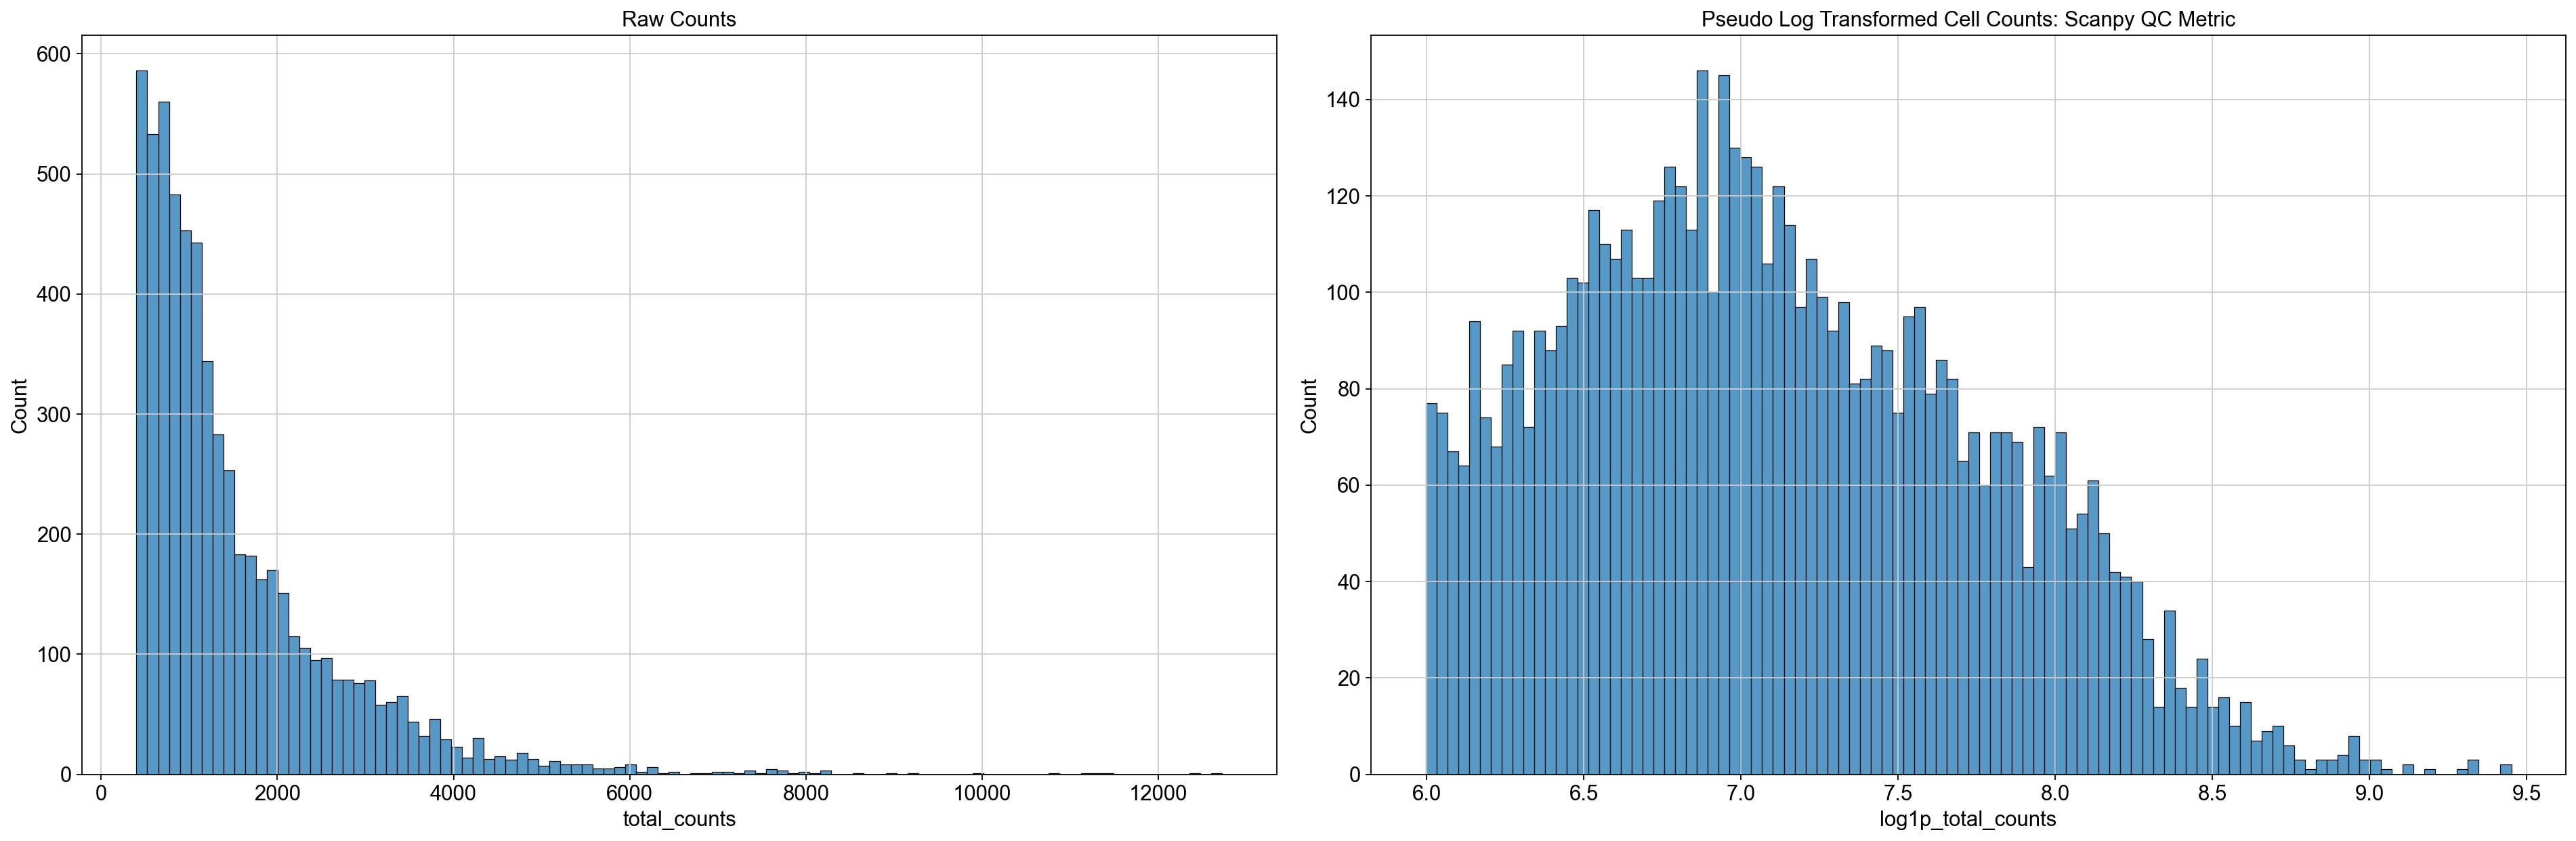

In [77]:
# Plot histograms
fig, ax = plt.subplots(1, 2, figsize=(24, 8))  

# Raw Counts Histogram
sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=ax[0])
ax[0].set_title("Raw Counts")

# Pseudo Log 
sns.histplot(adata.obs["log1p_total_counts"], bins=100, kde=False, ax=ax[1])
ax[1].set_title("Pseudo Log Transformed Cell Counts: Scanpy QC Metric")

# Display 
plt.tight_layout()  
plt.show();

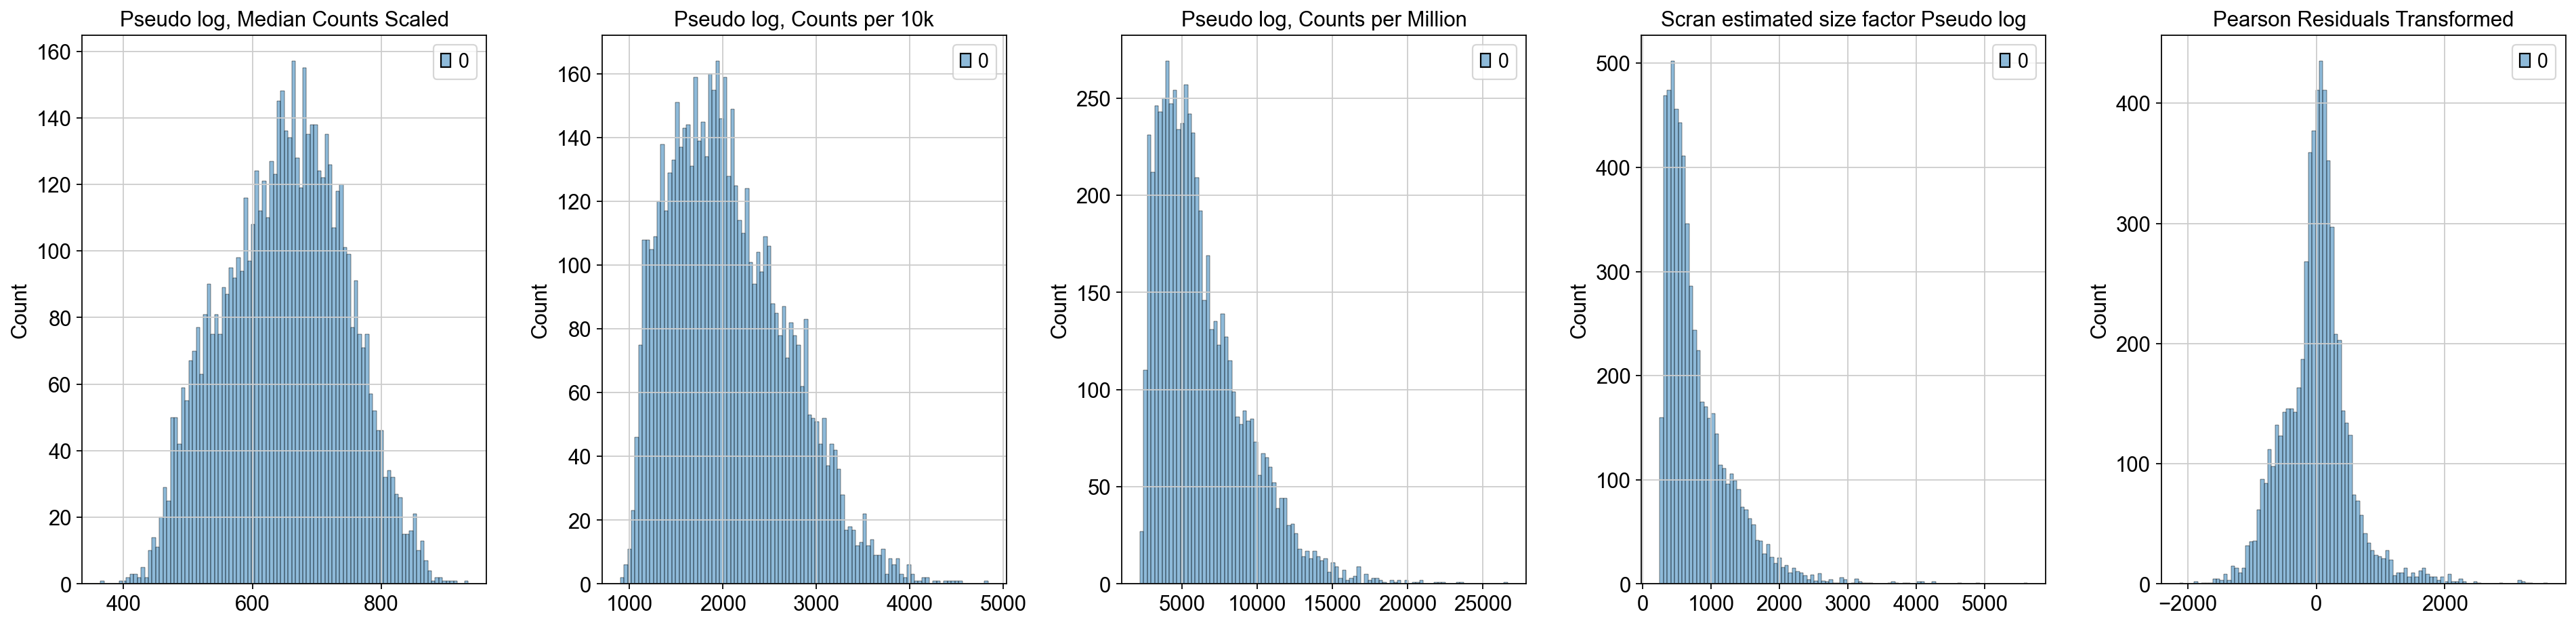

In [78]:
# Define a list of layers and titles
transform_tuple = [
    ("log1p-median", "Pseudo log, Median Counts Scaled"),
    ("log1p-CP10K", "Pseudo log, Counts per 10k"),
    ("log1p-CPM", "Pseudo log, Counts per Million"),
    ("scran_normalization", "Scran estimated size factor Pseudo log"),
    ("pearson_residuals", "Pearson Residuals Transformed")
]

# Call function
plot_layer_histograms(adata, transform_tuple)


After tranformation of our data, we want to see a close approximation of a normal distribution, in the shape of the iconic bell curve. This ensures that extreme values do not have an oversized influence on downstream analysis methods we choose to apply. In this case, the defaul approach of pseudolog transformation with normalization to total counts, as well as Pearsons Residual transformation appear to provide the best results. 

## Save Object

In [79]:
adata.write("data/C51ctr_Normalized.h5ad")

# End Session

In [80]:
import session_info
session_info.show()

c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\session_info\main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)
